# Import Statements

In [13]:
import OCR_pipeline as OCR
import TopicModeling as TM
import jsonpickle

[nltk_data] Downloading package punkt to /Users/kimberly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cleaning And Saving Extracted Text

In [14]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="XXX",
  database="forestry"
)
mycursor = mydb.cursor()

def getExtractedTexts():
    mycursor.execute("SELECT filename, extractedText FROM PolicyPapers")
    myresult = mycursor.fetchall()
    return [x for x in myresult]

def getExtractedTextsFromCountries(countries):
    sqlStatement = "SELECT filename, extractedText FROM PolicyPapers WHERE"
    
    for i in range(len(countries)):
        whereClause = " country = '%s' " % countries[i]
        sqlStatement += whereClause
        if len(countries) != 1 and i < len(countries) - 1:
            sqlStatement += "or"
            
    mycursor.execute(sqlStatement)
    myresult = mycursor.fetchall()
    return [x for x in myresult]

In [15]:
#dictionary for texts in terms of sentences
import re
import gc
textDictionary = {}
countries = ['India']
policyPapers = getExtractedTextsFromCountries(countries)
for paper in policyPapers:
    cleanWhitespaces = re.sub(r'(.) ', r'\1', paper[1])
    cleanedText = TM.toSentences(cleanWhitespaces)
    textDictionary[paper[0]] = cleanedText
   # gc.collect()

# LDA

In [4]:
from pprint import pprint
lemmatized_sents = []

# Print the Keywords in the 5 topics
for key in textDictionary:
    cleanedText = textDictionary[key]
    lemmatized_sents.extend(cleanedText)
    
corpus, lda_model = TM.LDA(lemmatized_sents)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
#Next Step: Store LDA data in Policy Paper Object & other central file

[(10,
  '0.043*"ciudad" + 0.038*"méxico" + 0.020*"secretario" + 0.018*"federal" + '
  '0.017*"dip" + 0.015*"diciembre" + 0.013*"sen" + 0.012*"constitución" + '
  '0.011*"espacio" + 0.011*"fuent"'),
 (19,
  '0.028*"residuos" + 0.024*"vigilancia" + 0.018*"mm" + 0.017*"articulo" + '
  '0.016*"vulnerable" + 0.016*"plagas" + 0.015*"incendio" + '
  '0.011*"enfermedade" + 0.011*"difusión" + 0.011*"final"'),
 (15,
  '0.048*"urban" + 0.024*"gas" + 0.022*"productividad" + 0.021*"plano" + '
  '0.018*"potencial" + 0.018*"reservas" + 0.012*"indicadore" + '
  '0.011*"elaborado" + 0.011*"pfc" + 0.010*"gerencia"'),
 (26,
  '0.056*"por" + 0.034*"metro" + 0.029*"ponto" + 0.028*"linha" + '
  '0.028*"coordenadas" + 0.027*"segue" + 0.027*"distância" + 0.026*"utm" + '
  '0.026*"chegar" + 0.026*"azimute"'),
 (27,
  '0.025*"aplicabl" + 0.024*"sin" + 0.021*"sujeto" + 0.020*"escala" + '
  '0.018*"perjuicio" + 0.015*"permiso" + 0.014*"dado" + 0.013*"lugar" + '
  '0.012*"domicilio" + 0.011*"acta"'),
 (5,
  '0.058

# Visualizations

### pyLDAvis

`pip install pyldavis`

Code source: https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
<br>
The area of the circles represent the prevalance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. 

In [6]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)

/Users/kimberly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.230297 -0.261464       1        1  13.421721
24    -0.099043 -0.011079       2        1  12.248004
1      0.324738 -0.151333       3        1   8.142127
25     0.227008 -0.085816       4        1   7.816864
13    -0.230431 -0.229454       5        1   6.045647
4      0.302243 -0.130936       6        1   5.571722
21    -0.213378 -0.228728       7        1   5.492270
3      0.292421 -0.112933       8        1   4.662455
12     0.231570 -0.090281       9        1   4.202144
20    -0.208397 -0.213555      10        1   4.173699
18    -0.110732 -0.072996      11        1   3.514151
6      0.216699 -0.030743      12        1   2.485535
28    -0.143339 -0.060005      13        1   2.108359
17     0.141713  0.030736      14        1   1.935273
29     0.166954  0.005265      15        1   1.853084
2     -0.070927  0.035373      16        1   1.693330
9     -0.069165  0.023304      17        1   1.671627
0      0.054805  0.081912      18        1   1.434975
22    -0.115225  0.028076      19        1   1.305166
10    -0.048715  0.117549      20        1   1.205328
26    -0.073036  0.099166      21        1   1.189406
7     -0.080329  0.089240      22        1   1.094067
11     0.001312  0.136330      23        1   1.037067
23    -0.039040  0.155211      24        1   0.907069
19    -0.053455  0.138896      25        1   0.848127
8     -0.030405  0.142055      26        1   0.816756
27    -0.070747  0.117382      27        1   0.804602
15    -0.037435  0.161943      28        1   0.796814
16    -0.032314  0.159242      29        1   0.781608
5     -0.003054  0.157643      30        1   0.741001, topic_info=      Category         Freq          Term        Total  loglift  logprob
term                                                                    
6      Default  9928.000000            be  9928.000000  30.0000  30.0000
403    Default  5077.000000            do  5077.000000  29.0000  29.0000
4121   Default  6390.000000           los  6390.000000  28.0000  28.0000
4192   Default  7122.000000            la  7122.000000  27.0000  27.0000
4117   Default  2922.000000      forestal  2922.000000  26.0000  26.0000
4150   Default  6802.000000          para  6802.000000  25.0000  25.0000
4203   Default  3817.000000           por  3817.000000  24.0000  24.0000
19     Default  4104.000000         shall  4104.000000  23.0000  23.0000
4165   Default  3311.000000      artículo  3311.000000  22.0000  22.0000
299    Default  3209.000000          land  3209.000000  21.0000  21.0000
4104   Default  1600.000000    secretaría  1600.000000  20.0000  20.0000
333    Default  2205.000000    government  2205.000000  19.0000  19.0000
197    Default  2231.000000          such  2231.000000  18.0000  18.0000
98     Default  1426.000000       general  1426.000000  17.0000  17.0000
4087   Default  1416.000000     forestale  1416.000000  16.0000  16.0000
4115   Default  1950.000000    desarrollo  1950.000000  15.0000  15.0000
9      Default  2064.000000           may  2064.000000  14.0000  14.0000
4120   Default  1729.000000           ley  1729.000000  13.0000  13.0000
1200   Default  2798.000000           con  2798.000000  12.0000  12.0000
676    Default  1804.000000        forest  1804.000000  11.0000  11.0000
340    Default  2136.000000         state  2136.000000  10.0000  10.0000
4626   Default  1032.000000        manejo  1032.000000   9.0000   9.0000
20     Default  1383.000000           act  1383.000000   8.0000   8.0000
6531   Default  1079.000000         rural  1079.000000   7.0000   7.0000
4093   Default  1151.000000      recursos  1151.000000   6.0000   6.0000
4099   Default  1802.000000        estado  1802.000000   5.0000   5.0000
4103   Default  3109.000000           que  3109.000000   4.0000   4.0000
4162   Default   917.000000     ambiental   917.000000   3.0000   3.0000
4516   Default   953.000000      servic

### WordCloud

`pip install wordcloud`

Code source: https://medium.com/@rudyb2001/making-sense-of-the-news-using-machine-learning-e13ed5f96cf0
<br>
WordCloud of Top 10 words in each topic with the sizes of the words proportional to the weights.

In [7]:
len(lda_model.show_topics(formatted=False))

10

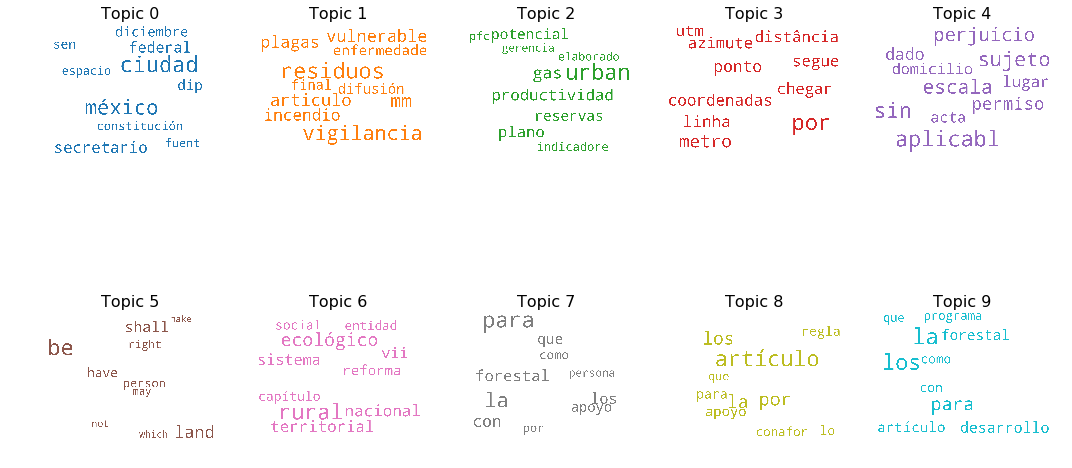

In [9]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Storage